In [202]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split as data_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Generate Moon Dataset

Shape of X_train : (1500, 2)
Shape of X_test  : (500, 2)
Shape of y_train : (1500,)
Shape of X_test  : (500,)


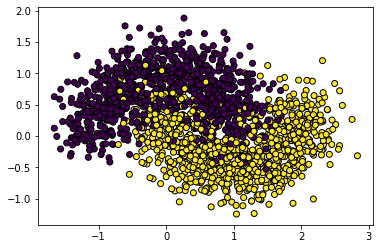

In [207]:
X_moon,y_moon = make_moons(n_samples= 2000, shuffle=True, noise=0.3 ,random_state=5)

plt.scatter(X_moon[:,0],X_moon[:,1], c=y_moon, edgecolors='k')

X_moon = pd.DataFrame(X_moon)
standardize_features = lambda x: (x - x.mean()) / x.std()
X_moon = standardize_features(X_moon).values

X_train, X_test, y_train, y_test = data_split(
    X_moon, y_moon,test_size=0.25, random_state=30)

print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of X_test  : {X_test.shape}")
print(f"Shape of y_train : {y_train.shape}")
print(f"Shape of X_test  : {y_test.shape}")

## Neural Network

In [277]:
class DeepForward:
    def __init__(self,layer_dims,activations):
        
        def gen_dims(dims_arr):
            layers = []
            for i in range(len(dims_arr) - 1):
                dim = (dims_arr[i+1],dims_arr[i])
                layers.append(dim)
            return layers        
       
        self._forward_data  = {"a":[],"w":[],"b":[],"z":[]}
        self._backward_data = {"da":[],"dw":[],"db":[],"dz":[]}
        self._layer_dims    = gen_dims(layer_dims) 
        self._activations   = activations
        self._net_depth     = len(self._layer_dims)
        self._train_loss    = []
        self._test_loss     = []
        self._train_acc     = []
        self._test_acc      = []
        
        
        
        
        for i in range(self._net_depth):
            dimen      = self._layer_dims[i]
            b_dimen    = (dimen[0],1)
            self._forward_data["w"].append(np.random.random(dimen))
            self._forward_data["b"].append(np.random.random(b_dimen))
            
            
    
    def __repr__(self):
        display_str = ""
        
        def act_name(x):
            if x == 0:
                return "sigmoid"
            elif x == 1:
                return "relu"
            else:
                return "tanh"
        
        w   = self._forward_data["w"]
        b   = self._forward_data["b"]
        act = list(map(act_name,self._activations))
        
        for i in range(self._net_depth):
            display_str += f"Layer {i}- Weight dims:{w[i].shape}, bias dims:{b[i].shape} activation: {act[i]}\n"
        return display_str
    
    def print_data_shape(self,data_type):
        data_type = "_"+data_type
        info      = self.__dict__[data_type]
        i = 0
        for k,v in info.items():
            for j in range(len(info[k])):
                if data_type == "_backward_data" and i == 0:
                    print(f"Layer {j+1} - {k}{j+1} dims:{info[k][j].shape}")
                else:    
                    print(f"Layer {j}- {k}{j} dims:{info[k][j].shape}")
            print("\n")
            i += 1
    
    def activation(self,z,act_type):
        if act_type == 0:
            return 1/(1+np.exp(-z))
        
        if act_type == 1:
            return np.maximum(z,0)
        
    def gradient(self,z,act_type):
          if act_type == 0:
            a = 1/(1+np.exp(-z))
            return a*(1-a)

          if act_type == 1:
            return (z > 0).astype(float)
            
        
 
    def forward(self,X):     
        a   = self._forward_data["a"] = []
        w   = self._forward_data["w"]
        b   = self._forward_data["b"]
        z   = self._forward_data["z"] = []
        act = self._activations
        
        self._forward_data["a"].append(X.T)
        
        for i in range(self._net_depth):
            z_new = w[i].dot(a[i]) + b[i]
            z.append(z_new)
            a_new = self.activation(z_new,act[i])
            a.append(a_new)
        
        return self
    
    def bce_loss(self,y,pred):
        loss = -(y*np.log(pred) + (1-y)*np.log(1-pred))
        return np.mean(loss)
        
    
    def backward(self,y,loss_type = 0):
        y   = y.reshape(1,-1)
        a   = self._forward_data["a"]
        w   = self._forward_data["w"]
        b   = self._forward_data["b"]
        z   = self._forward_data["z"]
        da,dw,db,dz = [],[],[],[]
        
        act = self._activations
        
        def reorder(arr,dim):
            order = list(reversed(range(dim)))
            return [arr[i] for i in order]
        
        if loss_type == 0:
            da_last = np.divide(1-y,1-a[-1]) - np.divide(y,a[-1])
            da.append(da_last)
        
        for i in reversed(range(self._net_depth)):
            dz_new = da_last * self.gradient(z[i],act[i])
            dw_new = dz_new.dot(a[i].T)
            db_new = np.mean(dz_new,axis=1,keepdims=1)
            
            dz.append(dz_new)
            dw.append(dw_new)
            db.append(db_new)
            
            if i != 0:
                da_new  = w[i].T.dot(dz_new)
                da_last = da_new
                da.append(da_new)
         
        self._backward_data["dz"] = reorder(dz,len(dz))
        self._backward_data["dw"] = reorder(dw,len(dw))
        self._backward_data["db"] = reorder(db,len(db))
        self._backward_data["da"] = reorder(da,len(da))
        return self
    
    def update(self,lr):
        w   = self._forward_data["w"]
        b   = self._forward_data["b"]
        dw  = self._backward_data["dw"] 
        db  = self._backward_data["db"]
        
        for i in range(len(w)):
            w[i] -= lr * dw[i]
            b[i] -= lr * db[i]
            
        return self
    
    
    def train(self,X,y,Xt,yt,lr,epochs,freq):
        for epoch in range(epochs):
            self.forward(X)
            pred = self._forward_data["a"][-1]
            loss = self.bce_loss(y,pred)
            self._train_loss.append(loss)
            self.backward(y,loss_type = 0)
            self.update(lr)
            
            #predictions for train set
            self.forward(X)
            pred = self._forward_data["a"][-1]
            acc = self.accuracy(y,pred)
            self._train_acc.append(acc)
            
            #predictions for train set
            self.forward(Xt)
            pred = self._forward_data["a"][-1]
            loss = self.bce_loss(yt,pred)
            acc = self.accuracy(yt,pred)
            self._test_loss.append(loss)
            self._test_acc.append(acc)
            
            if (epoch+1)%freq == 0:
                print(f"epoch:{epoch+1:2d} train loss:{self._train_loss[-1]:.3f} train acc:{self._train_acc[-1]:.3f}%")
                print(f"epoch:{epoch+1:2d} test loss:{self._test_loss[-1]:.3f} test acc:{self._test_acc[-1]:.3}%\n")
            
            if epoch!= epochs-1:
                self._forward_data["a"]  = []
                self._forward_data["z"]  = []
                self._backward_data = {"da":[],"dw":[],"db":[],"dz":[]}
            
        return self
    
    
    def accuracy(self,y,pred):
        pred = (pred>0.5).astype(int)
        return (np.mean(y == pred)).astype("float") * 100       

In [279]:
layer_dims  = [2,2,2,1]
activations = [1,1,0]
model = DeepForward(layer_dims,activations)
model.train(X_train,y_train,X_test,y_test,lr=0.01,epochs=1,freq=10)

Layer 0- Weight dims:(2, 2), bias dims:(2, 1) activation: relu
Layer 1- Weight dims:(2, 2), bias dims:(2, 1) activation: relu
Layer 2- Weight dims:(1, 2), bias dims:(1, 1) activation: sigmoid